In [1]:
import numpy as np
from statistics import mean
import re
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tqdm import tqdm
import os
from nltk.corpus import stopwords
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense,LSTM,Bidirectional,Flatten,Dropout,BatchNormalization,Embedding,Input,TimeDistributed
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import plot_model
from rouge import Rouge

In [7]:
from transformers import AutoModelWithLMHead, AutoTokenizer
model = AutoModelWithLMHead.from_pretrained("t5-small", return_dict=True)
tokenizer = AutoTokenizer.from_pretrained("t5-small")

In [8]:
bodyc=' The mind can be its own worst enemy sometimes… More so than any angry comment, uncaring action, or thoughtlessly spewed words by others to you. You say the worst things to yourself. You make yourself cry and you mean to make yourself cry. Why?'

In [9]:
inputs = tokenizer.encode("summarize: " + bodyc, return_tensors="pt", max_length=512)
outputs = model.generate(inputs, max_length=200, min_length=10, length_penalty=2.0, num_beams=4, early_stopping=True)
print(tokenizer.decode(outputs[0]))

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


the mind can be its own worst enemy sometimes... More so than any angry comment, uncaring action, or thoughtlessly spewed words by others to you. you make yourself cry and you mean to make yourself cry.


In [2]:
summary = pd.read_csv('/Users/apple/Downloads/bbc_news-master/generated_data/bbc_articles.tsv',sep='\t')
summary.head()

Unnamed: 0     genre                              title  \
0           0  business  Ad sales boost Time Warner profit   
1           1  business   Dollar gains on Greenspan speech   
2           2  business  Yukos unit buyer faces loan claim   
3           3  business  High fuel prices hit BA's profits   
4           4  business  Pernod takeover talk lifts Domecq   

                                            subtitle  \
0  Quarterly profits at US media giant TimeWarner...   
1  The dollar has hit its highest level against t...   
2  The owners of embattled Russian oil giant Yuko...   
3  British Airways has blamed high fuel prices fo...   
4  Shares in UK drinks and food firm Allied Domec...   

                                                text  token_counts  
0  The firm, which is now one of the biggest inve...           456  
1  And Alan Greenspan highlighted the US governme...           399  
2  State-owned Rosneft bought the Yugansk unit fo...           259  
3  Reporting its results for the three months to ...           450  
4  Reports in the Wall Street Journal and the Fin...           273

In [36]:
summary.iloc[0][3],summary.iloc[0][2]

('Quarterly profits at US media giant TimeWarner jumped 76% to $1.13bn (Â£600m) for the three months to December, from $639m year-earlier.',
 'Ad sales boost Time Warner profit')

In [26]:
path = '/Users/apple/Downloads/BBC News Summary/BBC News Summary'

all_data=[]
Articles_with_stopwords=[]
Articles_without_stopwords=[]
Summaries=[]
stop_words=set(stopwords.words('english'))
for d,path,filenames in tqdm(os.walk(path)):
    for file in filenames:
        if os.path.isfile(d+'/'+file):
            if('Summaries' in d+'/'+file):
                with open(d+'/'+file,'r',errors='ignore') as f:
                    summary=''.join([i.rstrip() for i in f.readlines()])
                    Summaries.append(summary)
                    f.close()
            else:
                with open(d+'/'+file,'r',errors='ignore') as f:
                    Article=''.join([i.rstrip() for i in f.readlines()])
                    Articles_with_stopwords.append(Article)
                    Articles_without_stopwords.append(' '.join([w for w in Article.split() if w not in stop_words]))
                    f.close()
        

13it [00:04,  3.10it/s]


In [2]:
data=pd.DataFrame({'Articles without stop words':Articles_without_stopwords,'Article with stop words': Articles_with_stopwords,'Summary':Summaries})
data.head()

NameError: name 'Articles_without_stopwords' is not defined

In [12]:
data=pd.read_csv('/Users/apple/Desktop/college 3rd year/data.csv',index_col=None)
data

Unnamed: 0                        Articles without stop words  \
0              0  musicians tackle us red groups tackle us visa ...   
1              1  desire number three prestigious grammy awards ...   
2              2  rocker doherty fightrock singer pete doherty i...   
3              3  snicket tops us box office chartthe film adapt...   
4              4  ocean twelve raids box officeocean crime caper...   
...          ...                                                ...   
2220        2220  warning windows word fileswriting microsoft wo...   
2221        2221  fast lifts rise record bookstwo lifts world ta...   
2222        2222  nintendo adds media playing dsnintendo releasi...   
2223        2223  fast moving phone viruses appearsecurity firms...   
2224        2224  hacker threat apple itunesusers apple music ju...   

                                Article with stop words  \
0     musicians to tackle us red groups are to tackl...   
1     desire to be number who have won three prestig...   
2     rocker doherty in fightrock singer pete dohert...   
3     snicket tops us box office chartthe film adapt...   
4     ocean twelve raids box officeocean the crime c...   
...                                                 ...   
2220  warning over windows word fileswriting a micro...   
2221  fast lifts rise into record bookstwo lifts at ...   
2222  nintendo adds media playing to dsnintendo is r...   
2223  fast moving phone viruses appearsecurity firms...   
2224  hacker threat to apple itunesusers of apple mu...   

                                                Summary  
0     nigel mccune from the union said british music...  
1     but they still want have to want to be the big...  
2     which he formed after his acrimonious departur...  
3     a series of unfortunate events also stars scot...  
4     ocean the crime caper sequel starring george b...  
...                                                 ...  
2220  writing a microsoft word document can be a dan...  
2221  the lifts take only seconds to whisk passenger...  
2222  nintendo is releasing an adapter for its ds ha...  
2223  the new strains of the cabir mobile phone viru...  
2224  security firm which notified users of the reco...  

[2225 rows x 4 columns]

In [13]:
data.iloc[0][1]

'musicians tackle us red groups tackle us visa regulations blamed hindering british chances succeeding across singer hoping perform us expect pay say british artists face an uphill struggle succeed thanks tough visa also seen the mmf general secretary james seller imagine orchestra every member would travel london visas us market seen holy grail one benchmarks we are still going fight get it still markets like india added mr a department culture sport spokeswoman aware people experiencing working us embassy record industry see a us embassy spokesman we aware entertainers require visas visas everything process applications we aware importance cultural exchange best facilitate'

In [14]:
#Contraction Mapping
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

def clean_text(text):
    
    text=text.lower()
    text=' '.join([contraction_mapping[i] if i in contraction_mapping.keys() else i for i in text.split()])
    text=re.sub(r'\(.*\)',"",text)
    text=re.sub("'s","",text)
    text=re.sub('"','',text)
    text=' '.join([i for i in text.split() if i.isalpha()])
    text=re.sub('[^a-zA-Z.]'," ",text)
    
    return text
#bodyc = clean_text(body)
data['Article with stop words']=data['Article with stop words'].apply(clean_text)
data['Articles without stop words']=data['Articles without stop words'].apply(clean_text)
data['Summary']=data['Summary'].apply(clean_text)
data['Summary']=data['Summary']

In [17]:
print(data['Article with stop words'][0])

musicians to tackle us red groups are to tackle us visa regulations which are blamed for hindering british chances of succeeding across the singer hoping to perform in the us can expect to pay who say british artists face an uphill struggle to succeed in the thanks to the tough visa which are also seen as the mmf general secretary james seller imagine if you were an orchestra from the every member would have to travel to london to have their visas us market is seen as the holy grail and one of the benchmarks of and we are still going to fight to get in it still very but there are other markets like india and added mr a department for culture and sport spokeswoman aware that people are experiencing and are working with the us embassy and record industry to see what we can do about a us embassy spokesman we are aware that entertainers require visas for visas and are doing everything we can to process those applications we are aware of the importance of cultural exchange and we will do ou

In [16]:
bodyc

'last an incident of a robbery was reported at the shopping the shopkeeper who has a shop in the complex said this incident to the local police station in the morning as they found out about the robbery in the according to the as he reached his shop in the he found that the door was already open and many valuable items were stolen from the he immediately contacted the nearby police station and filed a the shopkeeper hopes that the police catch the culprits as soon as possible so that he can recover the items that were stolen from his there have been multiple such complaints in the past few weeks in this and the police suspect that these robberies are somehow the shopkeepers association has issued a notice and asked everyone in the area to stay alert and immediately report any suspicious activity to the the robbery was a major and not many eyewitnesses were present at the time of the the nearby house had a cctv facing the shopping complex and was able to capture a few according to trust

In [16]:
!pip install wordcloud

You should consider upgrading via the '/usr/local/opt/python@3.8/bin/python3.8 -m pip install --upgrade pip' command.


In [17]:
str1=""
for i in range(data.shape[0]):
    str1=str1+ " " + data['Article with stop words'][i]
str1

' musicians to tackle us red groups are to tackle us visa regulations which are blamed for hindering british chances of succeeding across the singer hoping to perform in the us can expect to pay who say british artists face an uphill struggle to succeed in the thanks to the tough visa which are also seen as the mmf general secretary james seller imagine if you were an orchestra from the every member would have to travel to london to have their visas us market is seen as the holy grail and one of the benchmarks of and we are still going to fight to get in it still very but there are other markets like india and added mr a department for culture and sport spokeswoman aware that people are experiencing and are working with the us embassy and record industry to see what we can do about a us embassy spokesman we are aware that entertainers require visas for visas and are doing everything we can to process those applications we are aware of the importance of cultural exchange and we will do 

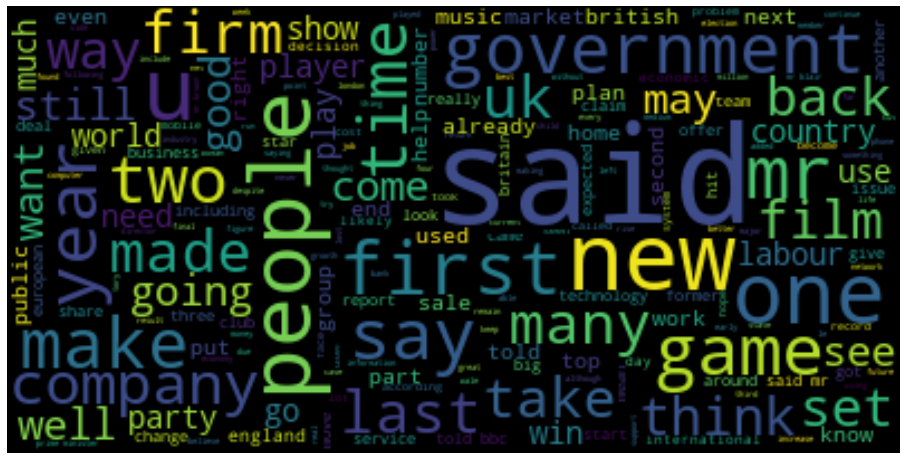

In [19]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
stop_words = set(stopwords.words('english'))
lemma = WordNetLemmatizer()
word_tokens = word_tokenize(str1) 
filtered_sentence = [w for w in word_tokens if not w in stop_words]
normalized = " ".join(lemma.lemmatize(word) for word in filtered_sentence)
from wordcloud import WordCloud
wordcloud = WordCloud(max_font_size=60).generate(normalized)
plt.figure(figsize=(16,12))

'''plot wordcloud in matplotlib'''

plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [24]:

count = {}
for w in normalized.split():
    if w in count:
        count[w] += 1
    else:
        count[w] = 1
for word, times in count.items():
    if times > 200:
        print("%s was found %d times" % (word, times))

u was found 1427 times
group was found 453 times
british was found 465 times
chance was found 260 times
across was found 203 times
pay was found 235 times
say was found 1009 times
face was found 311 times
also was found 1969 times
seen was found 297 times
general was found 322 times
secretary was found 250 times
every was found 281 times
member was found 264 times
would was found 2498 times
london was found 312 times
market was found 520 times
one was found 1494 times
still was found 562 times
going was found 580 times
get was found 895 times
like was found 772 times
added was found 243 times
mr was found 2638 times
people was found 1692 times
working was found 220 times
record was found 384 times
industry was found 327 times
see was found 541 times
spokesman was found 297 times
best was found 859 times
number was found 754 times
three was found 651 times
award was found 374 times
hit was found 375 times
biggest was found 250 times
band was found 224 times
thing was found 329 times
mus

In [5]:
X_train,X_val,Y_train,Y_val=train_test_split(data['Article with stop words'],data['Summary'],test_size=0.1,random_state=29)
print(len(X_train),len(Y_train))
print(len(X_val),len(Y_val))

2002 2002
223 223


# bert ext

In [9]:
from transformers import BertTokenizer, BertModel
import torch

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased', return_dict=True)

inputs = tokenizer("Hello, my dog is cute", return_tensors="pt")
outputs = model(**inputs)

last_hidden_states = outputs.last_hidden_state

In [10]:
last_hidden_states

tensor([[[-0.1144,  0.1937,  0.1250,  ..., -0.3827,  0.2107,  0.5407],
         [ 0.5308,  0.3207,  0.3665,  ..., -0.0036,  0.7579,  0.0388],
         [-0.4877,  0.8849,  0.4256,  ..., -0.6976,  0.4458,  0.1231],
         ...,
         [-0.7003, -0.1815,  0.3297,  ..., -0.4838,  0.0680,  0.8901],
         [-1.0355, -0.2567, -0.0317,  ...,  0.3197,  0.3999,  0.1795],
         [ 0.6080,  0.2610, -0.3131,  ...,  0.0311, -0.6283, -0.1994]]],
       grad_fn=<NativeLayerNormBackward>)

In [12]:
from transformers import BertTokenizer, BertForPreTraining
import torch

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForPreTraining.from_pretrained('bert-base-uncased', return_dict=True)

inputs = tokenizer("Hello, my dog is cute", return_tensors="pt")
outputs = model(**inputs)

prediction_logits = outputs.prediction_logits
seq_relationship_logits = outputs.seq_relationship_logits
seq_relationship_logits

Some weights of BertForPreTraining were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['cls.predictions.decoder.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tensor([[ 3.3474, -2.0613]], grad_fn=<AddmmBackward>)

In [12]:
data

Unnamed: 0                        Articles without stop words  \
0              0  musicians tackle us red groups tackle us visa ...   
1              1  desire number three prestigious grammy awards ...   
2              2  rocker doherty fightrock singer pete doherty i...   
3              3  snicket tops us box office chartthe film adapt...   
4              4  ocean twelve raids box officeocean crime caper...   
...          ...                                                ...   
2220        2220  warning windows word fileswriting microsoft wo...   
2221        2221  fast lifts rise record bookstwo lifts world ta...   
2222        2222  nintendo adds media playing dsnintendo releasi...   
2223        2223  fast moving phone viruses appearsecurity firms...   
2224        2224  hacker threat apple itunesusers apple music ju...   

                                Article with stop words  \
0     musicians to tackle us red groups are to tackl...   
1     desire to be number who have won three prestig...   
2     rocker doherty in fightrock singer pete dohert...   
3     snicket tops us box office chartthe film adapt...   
4     ocean twelve raids box officeocean the crime c...   
...                                                 ...   
2220  warning over windows word fileswriting a micro...   
2221  fast lifts rise into record bookstwo lifts at ...   
2222  nintendo adds media playing to dsnintendo is r...   
2223  fast moving phone viruses appearsecurity firms...   
2224  hacker threat to apple itunesusers of apple mu...   

                                                Summary  
0     nigel mccune from the union said british music...  
1     but they still want have to want to be the big...  
2     which he formed after his acrimonious departur...  
3     a series of unfortunate events also stars scot...  
4     ocean the crime caper sequel starring george b...  
...                                                 ...  
2220  writing a microsoft word document can be a dan...  
2221  the lifts take only seconds to whisk passenger...  
2222  nintendo is releasing an adapter for its ds ha...  
2223  the new strains of the cabir mobile phone viru...  
2224  security firm which notified users of the reco...  

[2225 rows x 4 columns]

In [6]:
from summarizer import Summarizer
model = Summarizer()

In [7]:
result = model(data['Article with stop words'].values[0][:30], min_length=40)
result

''

In [11]:
from summarizer import Summarizer
#body = "Last night, an incident of a robbery was reported at the shopping complex. The shopkeeper who has a shop in the complex said this incident to the local police station in the morning as they found out about the robbery in the morning. According to the shopkeeper, as he reached his shop in the morning, he found that the door was already open and many valuable items were stolen from the shop. He immediately contacted the nearby police station and filed a complaint. The shopkeeper hopes that the police catch the culprits as soon as possible so that he can recover the items that were stolen from his shop. There have been multiple such complaints in the past few weeks in this area, and the police suspect that these robberies are somehow connected. The shopkeepers association has issued a notice and asked everyone in the area to stay alert and immediately report any suspicious activity to the police. The robbery was a major one, and not many eyewitnesses were present at the time of the robbery. The nearby house had a CCTV facing the shopping complex and was able to capture a few details. According to trusted sources, the CCTV footage shows that there were a total of four robbers involved. Three of them came in a car, and the fourth one came on a bike. They broke into the shop and within 30-40 min came back with bags full of valuable items. They stuffed their bags into the car and rode back quickly before anyone could hear anything or see. The shopkeeper bore a severe loss, and the police have immediately started their investigation."
model = Summarizer()
result = model(bodyc, min_length=10)
full = ''.join(result)
print(full)

In [17]:
#model(data['Article with stop words'].values[1],ratio=0.2,min_length=60)
result = model(data['Article with stop words'].values[1],min_length=60)
full = ''.join(result)
print(full)

In [29]:
data['Article with stop words'].values[0]

'musicians to tackle us red groups are to tackle us visa regulations which are blamed for hindering british chances of succeeding across the singer hoping to perform in the us can expect to pay who say british artists face an uphill struggle to succeed in the thanks to the tough visa which are also seen as the mmf general secretary james seller imagine if you were an orchestra from the every member would have to travel to london to have their visas us market is seen as the holy grail and one of the benchmarks of and we are still going to fight to get in it still very but there are other markets like india and added mr a department for culture and sport spokeswoman aware that people are experiencing and are working with the us embassy and record industry to see what we can do about a us embassy spokesman we are aware that entertainers require visas for visas and are doing everything we can to process those applications we are aware of the importance of cultural exchange and we will do o

In [13]:
from rouge import Rouge
r1=[]
r2=[]
r3=[]
for i in range(0,1):
    ref=post_pre['summary'].values[i]
    pred=model(post_pre['text'].values[i], min_length=10)
    full = ''.join(pred)
    print(full)
    #pred=decode_sequence(x_tr[i].reshape(1,max_len_text))
    rouge=Rouge()
    scores=rouge.get_scores("".join(pred),ref,avg=True)
    r1.append(scores["rouge-1"]['f'])
    r2.append(scores["rouge-2"]['f'])
    #r3.append(scores["rouge-3"])

print("Rouge-1 ",r1,"\n")   
print("Rouge-2 ",r2,"\n")

ValueError: Hypothesis is empty.

In [47]:
data['Article with stop words'].values[0]

'musicians to tackle us red groups are to tackle us visa regulations which are blamed for hindering british chances of succeeding across the singer hoping to perform in the us can expect to pay who say british artists face an uphill struggle to succeed in the thanks to the tough visa which are also seen as the mmf general secretary james seller imagine if you were an orchestra from the every member would have to travel to london to have their visas us market is seen as the holy grail and one of the benchmarks of and we are still going to fight to get in it still very but there are other markets like india and added mr a department for culture and sport spokeswoman aware that people are experiencing and are working with the us embassy and record industry to see what we can do about a us embassy spokesman we are aware that entertainers require visas for visas and are doing everything we can to process those applications we are aware of the importance of cultural exchange and we will do o

# transformers

In [18]:
from transformers import pipeline

In [19]:
summarizer = pipeline("summarization")
print(summarizer(data['Article with stop words'].values[0], max_length=100, min_length=10, do_sample=False))

[{'summary_text': ' us red groups are to tackle us visa regulations which are blamed for hindering british chances of succeeding across the singer hoping to perform in the us can expect to pay . mmf general secretary james seller says brits artists face an uphill struggle to succeed in the thanks to the tough visa .'}]


In [20]:
ref=data['Summary'].values[0]
pred=summarizer(data['Article with stop words'].values[0], max_length=100, min_length=10, do_sample=False)
#pred=decode_sequence(x_tr[i].reshape(1,max_len_text))
rouge=Rouge()
scores=rouge.get_scores(pred[0]['summary_text'],ref,avg=True)
scores

{'rouge-1': {'f': 0.21782177718262927,
  'p': 0.21153846153846154,
  'r': 0.22448979591836735},
 'rouge-2': {'f': 0.0, 'p': 0.0, 'r': 0.0},
 'rouge-l': {'f': 0.1249999950000002, 'p': 0.125, 'r': 0.125}}

In [21]:
pred

[{'summary_text': ' us red groups are to tackle us visa regulations which are blamed for hindering british chances of succeeding across the singer hoping to perform in the us can expect to pay . mmf general secretary james seller says brits artists face an uphill struggle to succeed in the thanks to the tough visa .'}]

In [22]:
ref

'nigel mccune from the union said british musicians are disadvantaged compared to their us us embassy spokesman we are aware that entertainers require visas for visas and are doing everything we can to process those applications union stance is being endorsed by the music forum simply for obtaining a'

In [59]:
from rouge import Rouge
r1=[]
r2=[]
r3=[]
for i in range(0,2225):
    ref=data['Summary'].values[i]
    pred=summarizer(data['Article with stop words'].values[i], max_length=100, min_length=10, do_sample=False)
    #pred=decode_sequence(x_tr[i].reshape(1,max_len_text))
    rouge=Rouge()
    scores=rouge.get_scores(pred[0]['summary_text'],ref,avg=True)
    r1.append(scores["rouge-1"]['f'])
    r2.append(scores["rouge-2"]['f'])
    r3.append(scores["rouge-l"]['f'])

#print("Rouge-1 ",r1,"\n")   
#print("Rouge-2 ",r2,"\n")   
print(mean(r1),mean(r2),mean(r3))

Your max_length is set to 100, but you input_length is only 66. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 100, but you input_length is only 35. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 100, but you input_length is only 73. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 100, but you input_length is only 66. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 100, but you input_length is only 54. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 100, but you input_length is only 25. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 100, but you input_length is only 90. You might consider

IndexError: index out of range in self

In [55]:
data['Summary'].values[0]

'<START> nigel mccune from the union said british musicians are disadvantaged compared to their us us embassy spokesman we are aware that entertainers require visas for visas and are doing everything we can to process those applications union stance is being endorsed by the music forum simply for obtaining a <END>'

In [58]:
data.shape

(2225, 3)

In [60]:
mean(r1)

0.38856541201517153

In [61]:
mean(r2)

0.2799934137144095

In [62]:
mean(r3)

0.38877690262046155

# t5

In [19]:
from transformers import AutoModelWithLMHead, AutoTokenizer

model = AutoModelWithLMHead.from_pretrained("t5-base", return_dict=True)
tokenizer = AutoTokenizer.from_pretrained("t5-base")

/usr/local/lib/python3.8/site-packages/transformers/modeling_auto.py:821: FutureWarning: The class `AutoModelWithLMHead` is deprecated and will be removed in a future version. Please use `AutoModelForCausalLM` for causal language models, `AutoModelForMaskedLM` for masked language models and `AutoModelForSeq2SeqLM` for encoder-decoder models.
  warnings.warn(


In [20]:
from rouge import Rouge
r1=[]
r2=[]
r3=[]
for i in range(0,1):
    #ref=data['Summary'].values[i]
    inputs = tokenizer.encode("summarize: " + bodyc, return_tensors="pt", max_length=512)
    outputs = model.generate(inputs, max_length=200, min_length=10, length_penalty=2.0, num_beams=4, early_stopping=True)
    print(tokenizer.decode(outputs[0]))
    #pred=summarizer(post_pre['text'].values[i], max_length=130, min_length=10, do_sample=False)
    #pred=decode_sequence(x_tr[i].reshape(1,max_len_text))
#     rouge=Rouge()
     
#     scores=rouge.get_scores(tokenizer.decode(outputs[0]),ref,avg=True)
#     r1.append(scores["rouge-1"]['f'])
#     r2.append(scores["rouge-2"]['f'])
#     r3.append(scores["rouge-l"]['f'])

# print("Rouge-1 ",r1,"\n")   
# print("Rouge-2 ",r2,"\n")   
# print(mean(r1),mean(r2),mean(r3))

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


the shopkeeper who has a shop in the complex said this incident to the local police station in the morning as they found out about the robbery in the he immediately contacted the nearby police station and filed a the shopkeeper hopes that the police catch the culprits as soon as possible so that he can recover the items that were stolen from his there have been multiple complaints in the past few weeks in this and the police suspect that these robberies are somehow the shopkeepers association has issued a notice and asked everyone in


In [70]:
len(r1)

269

In [71]:
print(mean(r1),mean(r2),mean(r3))

0.4730948700150718 0.33761968474393367 0.42388587608488293


In [72]:
mean(r1)

0.4730948700150718

In [73]:
mean(r2)

0.33761968474393367

In [74]:
mean(r3)

0.42388587608488293

In [78]:
data.to_csv('/Users/apple/Desktop/data.csv')

# BART

In [21]:
from transformers import BartTokenizer, BartForConditionalGeneration, BartConfig

# see ``examples/summarization/bart/run_eval.py`` for a longer example
model = BartForConditionalGeneration.from_pretrained('facebook/bart-large-cnn')
tokenizer = BartTokenizer.from_pretrained('facebook/bart-large-cnn')

In [22]:
inputs = tokenizer(bodyc, max_length=1024, return_tensors='pt')

# Generate Summary
summary_ids = model.generate(inputs['input_ids'], num_beams=2, max_length=60, early_stopping=True)
a=[tokenizer.decode(g, skip_special_tokens=True, clean_up_tokenization_spaces=False) for g in summary_ids][0]
a

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


'Last week an incident of a robbery was reported at the shopping complex. The shopkeeper who has a shop in the complex said this incident to the local police station in the morning. The police suspect that these robberies are somehow the shopkeepers association has issued a notice and asked everyone in the'

In [12]:
b=data['Summary'].values[0]

In [13]:
rouge=Rouge()
scores=rouge.get_scores(a,b,avg=True)
scores

{'rouge-1': {'f': 0.28282827782879305, 'p': 0.28, 'r': 0.2857142857142857},
 'rouge-2': {'f': 0.04123710840259387,
  'p': 0.04081632653061224,
  'r': 0.041666666666666664},
 'rouge-l': {'f': 0.21621621124908705, 'p': 0.23529411764705882, 'r': 0.2}}

In [41]:
from rouge import Rouge
r1=[]
r2=[]
r3=[]
for i in range(0,2200):
    ref=data['Summary'].values[i]
    inputs = tokenizer([data['Article with stop words'].values[i]], max_length=1024, return_tensors='pt')
    summary_ids = model.generate(inputs['input_ids'], num_beams=2, max_length=60, early_stopping=True)
    summ = ([tokenizer.decode(g, skip_special_tokens=True, clean_up_tokenization_spaces=False) for g in summary_ids])[0]
#     inputs = tokenizer.encode("summarize: " + data['Article with stop words'].values[i], return_tensors="pt", max_length=512)
#     outputs = model.generate(inputs, max_length=100, min_length=10, length_penalty=2.0, num_beams=4, early_stopping=True)
    #pred=summarizer(post_pre['text'].values[i], max_length=130, min_length=10, do_sample=False)
    #pred=decode_sequence(x_tr[i].reshape(1,max_len_text))
    rouge=Rouge()
    scores=rouge.get_scores(summ,ref,avg=True)
    r1.append(scores["rouge-1"]['f'])
    r2.append(scores["rouge-2"]['f'])
    r3.append(scores["rouge-l"]['f'])
    print(i,end=' ')
# print("Rouge-1 ",r1,"\n")   
# print("Rouge-2 ",r2,"\n") 
print()
print(mean(r1),mean(r2),mean(r3))

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 

KeyboardInterrupt: 

In [42]:
print(mean(r1),mean(r2),mean(r3)) 

0.39995405331485023 0.28396238540492436 0.4051233148534784


In [43]:
mean(r1)

0.39995405331485023

In [44]:
mean(r2)

0.28396238540492436

In [45]:
mean(r3)

0.4051233148534784

# pegasus

In [23]:
from transformers import PegasusTokenizer, PegasusForConditionalGeneration
from typing import List

In [24]:
#PGE_ARTICLE = "PG&E stated it scheduled the blackouts in response to forecasts for high winds amid dry conditions. The aim is to reduce the risk of wildfires. Nearly 800 thousand customers were scheduled to be affected by the shutoffs which were expected to last through at least midday tomorrow."
mname = "google/pegasus-xsum"
model = PegasusForConditionalGeneration.from_pretrained(mname)
tok = PegasusTokenizer.from_pretrained(mname)

In [29]:
bodyc

'last an incident of a robbery was reported at the shopping the shopkeeper who has a shop in the complex said this incident to the local police station in the morning as they found out about the robbery in the according to the as he reached his shop in the he found that the door was already open and many valuable items were stolen from the he immediately contacted the nearby police station and filed a the shopkeeper hopes that the police catch the culprits as soon as possible so that he can recover the items that were stolen from his there have been multiple such complaints in the past few weeks in this and the police suspect that these robberies are somehow the shopkeepers association has issued a notice and asked everyone in the area to stay alert and immediately report any suspicious activity to the the robbery was a major and not many eyewitnesses were present at the time of the the nearby house had a cctv facing the shopping complex and was able to capture a few according to trust

In [25]:
#google/pegasus-cnn_dailymail 
mname2 = "google/pegasus-cnn_dailymail"
model2 = PegasusForConditionalGeneration.from_pretrained(mname2)
tok2 = PegasusTokenizer.from_pretrained(mname2)

In [27]:
batch = tok2.prepare_seq2seq_batch(src_texts=[bodyc])  # don't need tgt_text for inference
gen = model2.generate(**batch)  # for forward pass: model(**batch)
summary: List[str] = tok2.batch_decode(gen, skip_special_tokens=True)
#assert summary == "California's largest electricity provider has turned off power to tens of thousands of customers."

In [28]:
summary

['The shopkeeper who has a shop in the complex said this incident to the local police station in the morning as they found out about the robbery in the according to the as he reached his shop in the he found that the door was already open and many valuable items were stolen from the he immediately contacted the nearby police station and filed a the shopkeeper hopes that the police catch the culprits as soon as possible so that he can recover the items that were stolen from his there have been multiple such complaints in the past few weeks in this and the police suspect that these robberies are somehow the shopkeepers association has issued a notice and asked everyone in the area']

In [10]:
data['Article with stop words'][1]

'desire to be number who have won three prestigious grammy awards for their hit are stubbornly clinging to their status as one of the biggest bands in the most popular groups in the history of rock all have several things in the music must be inspired and appeal across generations and be if not always but such success is down to more than they have to be compelling charismatic and intelligent enough to make good decisions and keep their feet on the they also have to want they have to want to be the biggest band ever and not stop wanting the beatles had the rolling stones still have rem hold onto it and queen were it in a and have it in and keep churning it their new how to dismantle an atomic comes years after the schoolfriends got together in dublin and years after the joshua tree cemented their place on the rock may have lost some of the edginess and youthful force that propelled them to the but they have lost none of the desire or ability to craft songs and the first single from the

In [9]:
ref=data['Summary'].values[1]
# inputs = tokenizer([data['Article with stop words'].values[i]], max_length=1024, return_tensors='pt')
# summary_ids = model.generate(inputs['input_ids'], num_beams=2, max_length=60, early_stopping=True)
# summ = ([tokenizer.decode(g, skip_special_tokens=True, clean_up_tokenization_spaces=False) for g in summary_ids])[0]

rouge=Rouge()
scores=rouge.get_scores(summary[0],ref,avg=True)
scores

{'rouge-1': {'f': 0.2454308070527443,
  'p': 0.9038461538461539,
  'r': 0.1419939577039275},
 'rouge-2': {'f': 0.20472440713001427,
  'p': 0.7647058823529411,
  'r': 0.11818181818181818},
 'rouge-l': {'f': 0.3454545423652893,
  'p': 0.9047619047619048,
  'r': 0.21348314606741572}}

In [32]:
ref=data['Summary'].values[1]
# inputs = tokenizer([data['Article with stop words'].values[i]], max_length=1024, return_tensors='pt')
# summary_ids = model.generate(inputs['input_ids'], num_beams=2, max_length=60, early_stopping=True)
# summ = ([tokenizer.decode(g, skip_special_tokens=True, clean_up_tokenization_spaces=False) for g in summary_ids])[0]

rouge=Rouge()
scores=rouge.get_scores(summary[0],ref,avg=True)
scores

{'rouge-1': {'f': 0.2454308070527443,
  'p': 0.9038461538461539,
  'r': 0.1419939577039275},
 'rouge-2': {'f': 0.20472440713001427,
  'p': 0.7647058823529411,
  'r': 0.11818181818181818},
 'rouge-l': {'f': 0.3454545423652893,
  'p': 0.9047619047619048,
  'r': 0.21348314606741572}}

In [26]:
from rouge import Rouge

In [29]:
scores

{'rouge-1': {'f': 0.2727272677918389,
  'p': 0.3076923076923077,
  'r': 0.24489795918367346},
 'rouge-2': {'f': 0.02325580902109353,
  'p': 0.02631578947368421,
  'r': 0.020833333333333332},
 'rouge-l': {'f': 0.16216215719503302, 'p': 0.17647058823529413, 'r': 0.15}}

In [34]:
r1=[]
r2=[]
r3=[]
for i in range(0,2000):
    ref=data['Summary'].values[i]
    batch = tok2.prepare_seq2seq_batch(src_texts=[data['Article with stop words'].values[i]])  # don't need tgt_text for inference
    gen = model2.generate(**batch)  # for forward pass: model(**batch)
    summary: List[str] = tok2.batch_decode(gen, skip_special_tokens=True)
    rouge=Rouge()
    scores=rouge.get_scores(summary[0],ref,avg=True)
    r1.append(scores["rouge-1"]['f'])
    r2.append(scores["rouge-2"]['f'])
    r3.append(scores["rouge-l"]['f'])
    print(i,end=' ')
# print("Rouge-1 ",r1,"\n")   
# print("Rouge-2 ",r2,"\n") 
print()
print(mean(r1),mean(r2),mean(r3))

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 

KeyboardInterrupt: 

In [35]:
mean(r1)

0.4294813596031372

In [36]:
mean(r2)

0.2965806368179894

In [37]:
mean(r3)

0.40921136538448866